In [1]:
import glob
import pandas as pd
import numpy as np
import re

# Project idea and description...

The original paper explores the hypothesis of chilling effects being present in people's behaviour on Wikipedia, that's to say whether people will tend to be less active in sensitive domains knowing that they are being surveilled by the government. And the conclusion was that such an effect does indeed exist.

We aim in our extension to see whether those effects extend to Twitter.

The logic behind our choice is that Twitter is a platform of discussion more than it is a platform of learning. So the behaviour of people should be different than on Wikipedia.
We also know that people tend to get really vocal on Twitter, so we expect people to actually be more active in talking about those hot-topics as time progresses, especially given that the years 2013-2014 have seen a lot of terrorist-related activity throughout the world.

# Data aquisition

At first we need to obtain tweets containing the same keywords chosen in the original paper, to do so we use the Python module `Twint` (not to be confused with the Swiss payment method) to retrieve those tweets for our selected dates.
We only focus on Tweets in English to match the scope of the original paper.

We need to get all the following keywords from twitter :

* abu sayyaf
* afghanistan
* agro
* al-qaeda
* al-qaeda in the arabian peninsula
* al-qaeda in the islamic maghreb
* al-shabaab
* ammonium nitrate
* attack
* biological weapon
* car bomb
* chemical weapon
* conventional weapon
* dirty bomb
* eco-terrorism
* environmental terrorism
* euskadi ta askatasuna
* extremism
* farc
* fundamentalism,
* hamas
* hezbollah
* improvised explosive device
* iran
* iraq
* irish republican army
* islamist
* jihad
* nationalism
* nigeria
* nuclear
* nuclear enrichment
* pakistan
* palestine liberation front
* pirates
* plo
* political radicalism
* recruitment
* somalia
* suicide attack
* suicide bomber
* taliban
* tamil tigers
* tehrik-i-taliban pakistan
* terror
* terrorism
* weapons-grade
* yemen

## Scraping script

Bellow we demonstrate the script that we used to retreive the data using the `twint` module. As the scripts were run in a command line fashion we used the `argparse` module to give command line style arguments to the script like start/end dates and keywords. This script could then be executed on multiple machines to get the full 47 keyword datasets.

Example of the command : `python3 scraper.py -q "abu sayyaf"` or with an end date `python3 scraper.py -q "abu sayyaf" -e 2012-05-06`

```python
import twint
import argparse

# get arguments from command line
# only the keyword is required, the other have default values 
parser = argparse.ArgumentParser()
parser.add_argument('-q', '--query', type=str, required=True)
parser.add_argument('-s', '--start', type=str, default='2012-01-01')
parser.add_argument('-e', '--end', type=str, default='2014-09-01')
args = parser.parse_args()

config = twint.Config()
config.Limit = 5
config.Hide_output = False
config.Lang = "en"
config.Since = args.start
config.Until = args.end
config.Store_csv = True
config.Search = args.query
config.Output = "_".join([args.query, args.start, args.end]) + ".csv"
# make search
print(f'Running search for "{args.query}" between {args.start} and {args.end}.')
twint.run.Search(config)
```

We had to restart the scripts often as sometimes the network went down or it was hitting an error. The convinience was that the scraped results are automatically saved to the specified output file so that you don't lose 2 days of computing.

## Monitoring the scraping process

Scraping took a lot of time and the dataset we collected became quickly huge. Here are some insights and explanations.

The columns we decided to keep during the pre-processing step :
```python
keep_columns = ['id', 'conversation_id', 'created_at', 'date', 'time', 'user_id', 'username', 
                'name', 'tweet', 'language', 'mentions', 'urls', 'photos', 'replies_count', 
                'retweets_count', 'likes_count', 'hashtags', 'link', 'retweet', 'video', 
                'thumbnail', 'reply_to']
```

We also defined the column types to try and speed the loading :
```python
defined_types = {'id': 'int64', 'conversation_id': 'int64', 'date': 'str', 'time': 'str',
                 'user_id': 'int64', 'username': 'str', 'name': 'str', 'tweet': 'str', 
                 'language': 'category', 'mentions': 'str', 'urls': 'str', 'photos': 'str',
                 'replies_count': 'int64', 'retweets_count': 'int64', 'likes_count': 'int64',
                 'hashtags': 'str', 'link': 'str', 'retweet': 'bool', 'video': 'bool', 
                 'thumbnail': 'str', 'reply_to': 'str'}
```

The scraping was done locally and we gathered some informations to better understand the data we were dealling with :
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>keyword</th>
      <th>mem (RAM in bytes)</th>
      <th>length (tweets)</th>
      <th>load_time (seconds)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>abu sayyaf</td>
      <td>4865767</td>
      <td>31381</td>
      <td>0.235500</td>
    </tr>
    <tr>
      <th>1</th>
      <td>afghanistan</td>
      <td>968202453</td>
      <td>6246447</td>
      <td>45.314392</td>
    </tr>
    <tr>
      <th>2</th>
      <td>agro</td>
      <td>173245992</td>
      <td>1117696</td>
      <td>9.340182</td>
    </tr>
    <tr>
      <th>5</th>
      <td>al-qaeda</td>
      <td>122046622</td>
      <td>787386</td>
      <td>5.864598</td>
    </tr>
    <tr>
      <th>3</th>
      <td>al-qaeda in the arabian peninsula</td>
      <td>242026</td>
      <td>1558</td>
      <td>0.260090</td>
    </tr>
    <tr>
      <th>4</th>
      <td>al-qaeda in the islamic maghreb</td>
      <td>173973</td>
      <td>1119</td>
      <td>0.023007</td>
    </tr>
    <tr>
      <th>6</th>
      <td>al-shabaab</td>
      <td>18349519</td>
      <td>118373</td>
      <td>0.970689</td>
    </tr>
    <tr>
      <th>7</th>
      <td>ammonium nitrate</td>
      <td>2227611</td>
      <td>14361</td>
      <td>0.142450</td>
    </tr>
    <tr>
      <th>8</th>
      <td>biological weapon</td>
      <td>1440179</td>
      <td>9281</td>
      <td>0.071740</td>
    </tr>
    <tr>
      <th>9</th>
      <td>car bomb</td>
      <td>74192061</td>
      <td>478647</td>
      <td>3.209042</td>
    </tr>
    <tr>
      <th>10</th>
      <td>chemical weapon</td>
      <td>10538457</td>
      <td>67979</td>
      <td>0.562371</td>
    </tr>
    <tr>
      <th>11</th>
      <td>conventional weapon</td>
      <td>288886</td>
      <td>1858</td>
      <td>0.036680</td>
    </tr>
    <tr>
      <th>12</th>
      <td>dirty bomb</td>
      <td>9855551</td>
      <td>63573</td>
      <td>0.422941</td>
    </tr>
    <tr>
      <th>13</th>
      <td>eco-terrorism</td>
      <td>628197</td>
      <td>4047</td>
      <td>0.042559</td>
    </tr>
    <tr>
      <th>14</th>
      <td>environmental terrorism</td>
      <td>137222</td>
      <td>882</td>
      <td>0.015497</td>
    </tr>
    <tr>
      <th>15</th>
      <td>euskadi ta askatasuna</td>
      <td>228079</td>
      <td>1461</td>
      <td>0.014286</td>
    </tr>
    <tr>
      <th>16</th>
      <td>extremism</td>
      <td>55538658</td>
      <td>358294</td>
      <td>2.734478</td>
    </tr>
    <tr>
      <th>17</th>
      <td>farc</td>
      <td>553848730</td>
      <td>3573206</td>
      <td>26.877547</td>
    </tr>
    <tr>
      <th>18</th>
      <td>fundamentalism</td>
      <td>22248274</td>
      <td>143526</td>
      <td>1.583067</td>
    </tr>
    <tr>
      <th>19</th>
      <td>hamas</td>
      <td>648181655</td>
      <td>4181797</td>
      <td>32.523051</td>
    </tr>
    <tr>
      <th>20</th>
      <td>hezbollah</td>
      <td>40189679</td>
      <td>259277</td>
      <td>3.038919</td>
    </tr>
    <tr>
      <th>21</th>
      <td>improvised explosive device</td>
      <td>1452690</td>
      <td>9366</td>
      <td>0.159687</td>
    </tr>
    <tr>
      <th>22</th>
      <td>iran</td>
      <td>3270850074</td>
      <td>21102238</td>
      <td>273.121536</td>
    </tr>
    <tr>
      <th>23</th>
      <td>iraq</td>
      <td>1530368273</td>
      <td>9873323</td>
      <td>140.079643</td>
    </tr>
    <tr>
      <th>24</th>
      <td>irish republican army</td>
      <td>783019</td>
      <td>5041</td>
      <td>2.799364</td>
    </tr>
    <tr>
      <th>25</th>
      <td>islamist</td>
      <td>155708870</td>
      <td>1004562</td>
      <td>7.137926</td>
    </tr>
    <tr>
      <th>26</th>
      <td>jihad</td>
      <td>342291226</td>
      <td>2208310</td>
      <td>15.917475</td>
    </tr>
    <tr>
      <th>27</th>
      <td>nationalism</td>
      <td>47336082</td>
      <td>305374</td>
      <td>2.629160</td>
    </tr>
    <tr>
      <th>28</th>
      <td>nigeria</td>
      <td>3101185190</td>
      <td>20007626</td>
      <td>220.365958</td>
    </tr>
    <tr>
      <th>30</th>
      <td>nuclear</td>
      <td>1528390409</td>
      <td>9860563</td>
      <td>72.915037</td>
    </tr>
    <tr>
      <th>29</th>
      <td>nuclear enrichment</td>
      <td>3812867</td>
      <td>24593</td>
      <td>8.927966</td>
    </tr>
    <tr>
      <th>31</th>
      <td>palestine liberation front</td>
      <td>17231</td>
      <td>109</td>
      <td>2.133325</td>
    </tr>
    <tr>
      <th>32</th>
      <td>pirates</td>
      <td>2616191136</td>
      <td>16878632</td>
      <td>160.441553</td>
    </tr>
    <tr>
      <th>33</th>
      <td>plo</td>
      <td>201551066</td>
      <td>1300318</td>
      <td>15.027318</td>
    </tr>
    <tr>
      <th>34</th>
      <td>political radicalism</td>
      <td>60933</td>
      <td>391</td>
      <td>0.422480</td>
    </tr>
    <tr>
      <th>35</th>
      <td>recruitment</td>
      <td>970214011</td>
      <td>6259425</td>
      <td>44.130364</td>
    </tr>
    <tr>
      <th>36</th>
      <td>somalia</td>
      <td>321910033</td>
      <td>2076819</td>
      <td>15.855634</td>
    </tr>
    <tr>
      <th>37</th>
      <td>suicide attack</td>
      <td>24404292</td>
      <td>157436</td>
      <td>1.422346</td>
    </tr>
    <tr>
      <th>38</th>
      <td>suicide bomber</td>
      <td>76492889</td>
      <td>493491</td>
      <td>3.353994</td>
    </tr>
    <tr>
      <th>39</th>
      <td>taliban</td>
      <td>598092678</td>
      <td>3858642</td>
      <td>26.805472</td>
    </tr>
    <tr>
      <th>40</th>
      <td>tamil tigers</td>
      <td>1250932</td>
      <td>8060</td>
      <td>0.681614</td>
    </tr>
    <tr>
      <th>41</th>
      <td>tehrik-i-taliban pakistan</td>
      <td>218540</td>
      <td>1404</td>
      <td>0.054258</td>
    </tr>
    <tr>
      <th>42</th>
      <td>terror</td>
      <td>2362431328</td>
      <td>15241472</td>
      <td>127.771983</td>
    </tr>
    <tr>
      <th>43</th>
      <td>terrorism</td>
      <td>481497811</td>
      <td>3106417</td>
      <td>27.226853</td>
    </tr>
    <tr>
      <th>44</th>
      <td>weapons-grade</td>
      <td>4045884</td>
      <td>26092</td>
      <td>0.893699</td>
    </tr>
    <tr>
      <th>45</th>
      <td>yemen</td>
      <td>519440710</td>
      <td>3351210</td>
      <td>25.210480</td>
    </tr>
  </tbody>
</table>

Loading all files simutaneously would take 20.86GB of memory.

We got 134 million tweets over the 32 months of the periode accross the 46 keywords.


## Understanding the distribution of our data

The most active topics in our keyword list are :
- iran
- nigeria
- pirates
- terror

All four with more than 10 million tweets.

The least active keywords are :
- environmental terrorism
- political radicalism
- palestine liberation front

They have less than 1000 tweets.

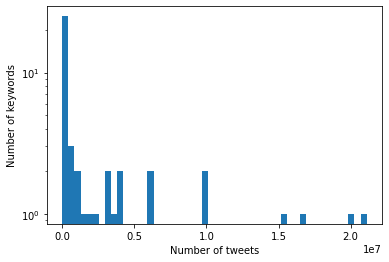

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
stats_df = pd.read_csv('stats_df.csv')
plt.hist(stats_df.length, bins=50)
# plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of keywords')
plt.xlabel('Number of tweets')
plt.show()

Here we can see that a lot of the keywords have not too much tweets and just a few kewords have a big number of tweets, it's powerlaw time again !

We would like to adress some caveats, as can be seen in the table and in the datastory, we did not manage to aggregate the data for the keyword `attack`and `pakistan` in time to showcase in this notebook.

## Data Wrangling

The data as retrieved is quite messy (as Tweets tend to be) and it's not all in English, so we first filter the dataframes by language since some non-English Tweets do slip by Twint's filter.

We tried using an aggressive approach to filter all entries containing non-standard characters using regex, this heavy approach seemed to be subpar leaving non-English tweets and removing some English ones.

We opted to just filtering by the column `language` and saving cleaned CSVs for the next step, this has been replaced by a single line in the aggregation step. So this code is here just for decoration and isn't really used anymore

```python
from os import scandir

data_path = './data/'
cleaned_data_path = data_path + 'cleaned/'
for element in scandir(data_path):
    if element.name.endswith('.gz'):
        df = pd.read_csv(data_path+element.name, lineterminator='\n', encoding='UTF-8', compression='gzip')
        df['tweet'] = df.tweet.str.replace(r'http\S+', 'URL').str.replace(r'@\S+', 'TWITTER_HANDLE').str.replace(r'#\S+', 'HASHTAG')
        df = df[df.language == 'en']
        # Alternatively, drop all rows having non-standard characters
        #df.drop(df[df.tweet.str.contains(fr'[^a-zA-Z!@#►&^$%~“”»`\[\]…:/‘’?–+=―•.;,_—\'\"\-\(\)\d\s{get_emoji_regexp().pattern}]')].index, inplace=True)
        df.to_csv(cleaned_data_path+element.name, compression='gzip')
```

Then we have the issue of having non-relevant Tweets slipping into our dataset, those have been among the highlights of this project, here's a sample:

For the keyword `dirty bomb` we found the following tweets in the data:

* I got really cheap bath bombs &amp; instead of turning my water a pretty color it just made my bath look dirty😑😖
* "I'm not a dirty whore, I bathe and I don't get paid. I'm a nice lady who gives bomb ass blowjobs " well folks, there you have it ; )

and for the keyword `Jihad`
* Wheres the loves for JIHAD AMARI JONES??

At first we tried to filter each dataframe by dropping all tweets containing "positive" words chosen per dataframe (e.g. the word `love` for `jihad`), but that ended up eliminating a good portion of Tweets that were actually relevant to our topic such as the following:

* "What does #Jihad really mean?" To struggle for love and to condemn hate #MyJihad featured in #Urdunewspaper #India.

And so we chose to keep those irrelevant Tweets that we deem to be a minority in the dataset and proceed to the modelling step.


## Analysis of the tweets

### Interrupted time series with regression
We will now focus on getting an understanding of the tweet distribution over time, and how the massive revelations of online surveillance in June 2013 might have caused a chilling effect. We will follow the paper's original way of doing the interrupted time series, with regression analysis.

First, let's see what those big files yield by reading one. We need to first find all the archives.

In [3]:
archive_pathnames = glob.glob('./data/*.gz')
print(f"Found {len(archive_pathnames)} archives")

Found 46 archives


Now, what is in the first archive ?

In [4]:
df = pd.read_csv(archive_pathnames[0])
print(df.shape)
df.head()

(9299, 22)


,id,conversation_id,created_at,date,time,user_id,username,name,tweet,language,...,photos,replies_count,retweets_count,likes_count,hashtags,link,retweet,video,thumbnail,reply_to
0,506278868614148097,506278868614148097,2014-09-01 05:14:23 CEST,2014-09-01,05:14:23,8.343178e+07,starman1981,truckerstrong news,ISIS laptop reveals terror group were working ...,en,...,[],0,0.0,0.0,[],https://twitter.com/starman1981/status/5062788...,False,False,NaN,[]
1,506272708037214208,506272708037214208,2014-09-01 04:49:54 CEST,2014-09-01,04:49:54,7.134575e+08,patriotsorg,Patriots Billboard,#SEIZED ISIS LAPTOP REVEALS THEY’RE DEVELOPING...,en,...,[],0,3.0,1.0,['seized'],https://twitter.com/PatriotsOrg/status/5062727...,False,False,NaN,[]
2,506263382459428864,506263382459428864,2014-09-01 04:12:50 CEST,2014-09-01,04:12:50,2.630728e+08,mlgeek,My Little Geek,@bjorntipling Perhaps Swift is a biological we...,en,...,[],0,0.0,0.0,[],https://twitter.com/mlgeek/status/506263382459...,False,False,NaN,[]
3,506261754197061632,506261754197061632,2014-09-01 04:06:22 CEST,2014-09-01,04:06:22,2.510451e+09,msgubot,Cédric Moro (backup),G+ #ebola USA created Ebola virus as biologica...,en,...,[],0,0.0,0.0,['ebola'],https://twitter.com/MSGUBOT/status/50626175419...,False,False,NaN,[]
4,506239829819281408,506239829819281408,2014-09-01 02:39:15 CEST,2014-09-01,02:39:15,7.134575e+08,patriotsorg,Patriots Billboard,#SEIZED ISIS LAPTOP REVEALS THEY’RE DEVELOPING...,en,...,[],1,2.0,1.0,['seized'],https://twitter.com/PatriotsOrg/status/5062398...,False,False,NaN,[]


We see a lot of information there. But what we are interested in is the user interactions around a topic that they might the government to track, for example. Therefore, we can count the number of tweets themselves, not any of their content or information, but also the number of likes and rerplies ! Each of these actions can make the user fear such surveillance. Retweets also, but because we also collect the retweets themselves, they are already there ! Therefore, we will first count the number of tweets per month, with the number of likes and retweets added as well.

In [5]:
# Keep only interesting columns and sum them all together by month. We set to parse dates so we can group by month
df = pd.read_csv(archive_pathnames[0], usecols=["date", "likes_count", "replies_count"], parse_dates=["date"], lineterminator='\n')
df["tweet_count"] = 1
grouped_df = df.set_index('date').groupby(pd.Grouper(freq='M')).sum()
grouped_df["user_interactions"] = grouped_df["likes_count"] +  grouped_df["tweet_count"] +  grouped_df["replies_count"]

grouped_df.head()

,replies_count,likes_count,tweet_count,user_interactions
date,,,,
2012-01-31,49,51,207,307
2012-02-29,33,27,177,237
2012-03-31,37,10,192,239
2012-04-30,40,32,156,228
2012-05-31,46,17,237,300


We will want to merge all twitter keyworkds into the same dataframe, therefore we will give the name of the keywork to the column where all values are summed, instead of just user_interactions. Let's extract the name from the archive path.

In [6]:
print(archive_pathnames[0])

./data/biological weapon_full.gz


In [7]:
# Knowing what the file path looks like, we can extract the name
name = re.search(r"(?<=data/).*?(?=_full)", archive_pathnames[0]).group(0)
name

'biological weapon'

In [8]:
# Just set this name to the column and go to the next zip !
grouped_df.rename(columns={"user_interactions": name}, inplace=True)
grouped_df.head()

,replies_count,likes_count,tweet_count,biological weapon
date,,,,
2012-01-31,49,51,207,307
2012-02-29,33,27,177,237
2012-03-31,37,10,192,239
2012-04-30,40,32,156,228
2012-05-31,46,17,237,300


Let's now implement a for loop to aggregate all the data.

In [ ]:
# print(pd.read_csv(archive_pathnames[0], usecols=["date", "likes_count"]))
monthly_counts = pd.DataFrame([])

for archive_pathname in archive_pathnames:
    print(f"Reading {archive_pathname} file")
    df = pd.read_csv(archive_pathname, usecols=["date", "likes_count", "replies_count"], parse_dates=["date"], lineterminator='\n')
    print(f"Shape is : {df.shape} \n")

    df["tweet_count"] = 1
    df = df.set_index('date').groupby(pd.Grouper(freq='M')).sum()
    df["user_interactions"] = df["likes_count"] +  df["tweet_count"] +  df["replies_count"]
    name = re.search(r"(?<=data/).*?(?=_full)", archive_pathname).group(0)

    df.rename(columns={"user_interactions": name}, inplace=True)
    
    monthly_counts = pd.concat([monthly_counts, df[name]], axis=1)
monthly_counts.index = pd.to_datetime(monthly_counts.index) # Make sure it is datetime

Reading ./data/biological weapon_full.gz file
Shape is : (9281, 3) 

Reading ./data/nuclear_full.gz file
Shape is : (9860563, 3) 

Reading ./data/improvised explosive device_full.gz file
Shape is : (9366, 3) 

Reading ./data/iran_full.gz file
Shape is : (21102238, 3) 

Reading ./data/nuclear enrichment_full.gz file
Shape is : (24593, 3) 

Reading ./data/hamas_full.gz file
Shape is : (4181797, 3) 

Reading ./data/extremism_full.gz file
Shape is : (358294, 3) 

Reading ./data/environmental terrorism_full.gz file
Shape is : (882, 3) 

Reading ./data/al-qaeda in the islamic maghreb_full.gz file
Shape is : (1119, 3) 

Reading ./data/taliban_full.gz file
Shape is : (3858642, 3) 

Reading ./data/abu sayyaf_full.gz file
Shape is : (31381, 3) 

Reading ./data/yemen_full.gz file
Shape is : (3351210, 3) 

Reading ./data/agro_full.gz file
Shape is : (1117696, 3) 

Reading ./data/islamist_full.gz file
Shape is : (1004562, 3) 

Reading ./data/al-qaeda_full.gz file
Shape is : (787386, 3) 

Reading ./

In [ ]:
print(f"We have {np.round(monthly_counts.sum().sum()/1000000, 2)} million actions !")

In [ ]:
# Temporary to get working faster !
# monthly_counts.to_csv("./monthly_actions.csv")
# monthly_counts = pd.read_csv("./monthly_actions.csv")

We will now have a quick glance at all the values we have.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# define figure
fig = plt.figure(figsize=(20, 16))

# big frame for main labels
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, pad=60)
plt.grid(False)
plt.xlabel("Months", fontsize=22)
plt.ylabel("Views", fontsize=22)

# define number of columns and rows of plot
col = 4
row = len(monthly_counts.columns)//col

# plot all topics
ax = fig.subplots(row, col, sharey=False, sharex=True)

for i, article_name in enumerate(monthly_counts):
    axis = ax[i//col, i%col]
    sns.lineplot(data=monthly_counts[f"{article_name}"], ax=axis)
    axis.set_title(article_name)
    plt.setp(axis.get_xticklabels(), rotation=30, horizontalalignment='right')
    axis.set_ylabel("")
fig.tight_layout()

With this graph we can look for missing values, or things that look anormal. TODO : discuss the weird things once we have complete data

In the original article, they study the period of 32 months from january 2012 to end of august 2014. We will therefore restrict our period to the be the same.

In [ ]:
studied_article_actions = monthly_counts["2012-01-01":"2014-08-31"]

And now we will create the interrupted time series plot, without regression first :

In [ ]:
import numpy as np
all_actions = pd.DataFrame(studied_article_actions.sum(axis=1), columns=["actions"])
all_actions["month_nb"] = range(1, 33)

after_revelations_month = 17 # 16 first months including June 2013, but index starts at 0 so we add 1 

# define figure
fig = plt.figure(figsize=(10, 5))

# big frame for main labels
plt.title("Monthly actions on all topics")
plt.xlabel("Months")
plt.ylabel("Total Actions")
plt.xticks(np.arange(0, 33, 2.0))
plt.scatter(x=all_actions["month_nb"], y=all_actions.actions)
plt.axvline(after_revelations_month+0.5, color='orange', label='Mid June 2013') # Plot a vertical line mid June 
plt.legend()
plt.show()

Now we will do the regression, to compare the trend before and after the studied interruption.

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Do linear regression with ols
mod_before = smf.ols(formula='actions ~ month_nb',
              data=all_actions[:after_revelations_month])
res_before = mod_before.fit()

mod_after = smf.ols(formula='actions ~ month_nb',
              data=all_actions[after_revelations_month:])
res_after = mod_after.fit()

before_intercept = res_before.params[0]
before_slope = res_before.params[1]

after_intercept = res_after.params[0]
after_slope = res_after.params[1]

print(f"Before period has intercept={before_intercept} and slope={before_slope}")

print(f"After period has intercept={after_intercept} and slope={after_slope}")

And now, we will plot both regressions, on each side of the interruption :

In [ ]:
# define figure
fig = plt.figure(figsize=(10, 7))

# big frame for main labels
plt.title("Interrupted regression of twitter actions across keywords")
plt.xlabel("Months")
plt.ylabel("Total actions")
plt.xticks(np.arange(0, 33, 2.0))
plt.scatter(x=range(1, 33), y=all_actions.actions)
plt.axvline(after_revelations_month+0.5, color='orange', label='Mid June 2013') # Plot a vertical line mid June 

# Now we'll add the before period regression line
plt.plot(all_actions[:after_revelations_month].month_nb, all_actions[:after_revelations_month].month_nb*before_slope+before_intercept, label="Trend Pre-June 2013")

# And the after period
plt.plot(all_actions[after_revelations_month:].month_nb, all_actions[after_revelations_month:].month_nb*after_slope+after_intercept, label="Trend Post-June 2013")

plt.legend()
plt.show()